VICON DATA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display plots inline
%matplotlib inline


In [2]:
# Path to your VICON CSV file
# Load the CSV file
df = pd.read_csv("/home/cpsl/px4_ws/attack3_log36/csv_out/vicon__x500_7__x500_7.csv")

# Show basic info
print("Data summary:")
df.info()

# Display first few rows
df.head()


Data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   t                        1650 non-null   float64
 1   t_rel                    1650 non-null   float64
 2   header.stamp             1650 non-null   float64
 3   header.frame_id          1650 non-null   object 
 4   header.stamp.sec         1650 non-null   int64  
 5   header.stamp.nanosec     1650 non-null   int64  
 6   child_frame_id           1650 non-null   object 
 7   transform.translation.x  1650 non-null   float64
 8   transform.translation.y  1650 non-null   float64
 9   transform.translation.z  1650 non-null   float64
 10  transform.rotation.x     1650 non-null   float64
 11  transform.rotation.y     1650 non-null   float64
 12  transform.rotation.z     1650 non-null   float64
 13  transform.rotation.w     1650 non-null   float64
dtypes: float64

,t,t_rel,header.stamp,header.frame_id,header.stamp.sec,header.stamp.nanosec,child_frame_id,transform.translation.x,transform.translation.y,transform.translation.z,transform.rotation.x,transform.rotation.y,transform.rotation.z,transform.rotation.w
0,1.760387e+09,0.000000,1.760387e+09,vicon/world,1760387113,502202053,vicon/x500_7/x500_7,0.112132,-0.243017,0.924303,-0.002418,-0.013515,0.029173,0.999480
1,1.760387e+09,0.017522,1.760387e+09,vicon/world,1760387113,506179761,vicon/x500_7/x500_7,0.112079,-0.243074,0.924337,-0.002354,-0.013600,0.028896,0.999487
2,1.760387e+09,0.044381,1.760387e+09,vicon/world,1760387113,516876675,vicon/x500_7/x500_7,0.111983,-0.243061,0.924337,-0.002527,-0.014684,0.027330,0.999515
3,1.760387e+09,0.061804,1.760387e+09,vicon/world,1760387113,526812157,vicon/x500_7/x500_7,0.112073,-0.243195,0.924418,-0.002267,-0.013048,0.029175,0.999487
4,1.760387e+09,0.085023,1.760387e+09,vicon/world,1760387113,536980888,vicon/x500_7/x500_7,0.112268,-0.243285,0.924467,-0.001906,-0.012276,0.030135,0.999469


In [3]:
# Extract ENU position components
x_e = df["transform.translation.x"].to_numpy()  # East
y_e = df["transform.translation.y"].to_numpy()  # North
z_e = df["transform.translation.z"].to_numpy()  # Up

# Convert to NED
x_n = y_e              # North
y_n = x_e              # East
z_n = -z_e             # Down

# Add to DataFrame
df["pos_north"] = x_n
df["pos_east"]  = y_n
df["pos_down"]  = z_n

print("✅ Converted ENU → NED position.")
df[["pos_north", "pos_east", "pos_down"]].head()


✅ Converted ENU → NED position.


,pos_north,pos_east,pos_down
0,-0.243017,0.112132,-0.924303
1,-0.243074,0.112079,-0.924337
2,-0.243061,0.111983,-0.924337
3,-0.243195,0.112073,-0.924418
4,-0.243285,0.112268,-0.924467


In [4]:
# --- Extract Vicon quaternion columns (FLU in ENU world) ---
qx = df["transform.rotation.x"].to_numpy(dtype=float)
qy = df["transform.rotation.y"].to_numpy(dtype=float)
qz = df["transform.rotation.z"].to_numpy(dtype=float)
qw = df["transform.rotation.w"].to_numpy(dtype=float)

# (Recommended) normalize to guard against tiny numeric drift
qnorm = np.sqrt(qx*qx + qy*qy + qz*qz + qw*qw)
good  = qnorm > 0
qx[good] /= qnorm[good]; qy[good] /= qnorm[good]
qz[good] /= qnorm[good]; qw[good] /= qnorm[good]


In [5]:
import numpy as np

# ----- fixed transforms -----
Cw = np.array([[0, 1, 0],   # ENU -> NED (world)
               [1, 0, 0],
               [0, 0,-1]], dtype=float)

Cb = np.array([[ 1, 0, 0],  # FLU -> FRD (body) = 180° roll
               [ 0,-1, 0],
               [ 0, 0,-1]], dtype=float)

def quat_array_to_rotmat(qx, qy, qz, qw):
    """
    qx,qy,qz,qw: shape (N,) arrays
    return: R of shape (N,3,3) mapping FLU to ENU
    """
    x, y, z, w = qx, qy, qz, qw
    xx, yy, zz = x*x, y*y, z*z
    xy, xz, yz = x*y, x*z, y*z
    wx, wy, wz = w*x, w*y, w*z

    R = np.empty((x.shape[0], 3, 3), dtype=float)
    R[:,0,0] = 1 - 2*(yy+zz)
    R[:,0,1] = 2*(xy - wz)
    R[:,0,2] = 2*(xz + wy)

    R[:,1,0] = 2*(xy + wz)
    R[:,1,1] = 1 - 2*(xx+zz)
    R[:,1,2] = 2*(yz - wx)

    R[:,2,0] = 2*(xz - wy)
    R[:,2,1] = 2*(yz + wx)
    R[:,2,2] = 1 - 2*(xx+yy)
    return R

# --- your quaternion columns (1D arrays) ---
# qx,qy,qz,qw = df["...x"].to_numpy(), ...

# Build FLU->ENU rotation, shape (N,3,3)
R_enu = quat_array_to_rotmat(qx, qy, qz, qw)

# ENU->NED (world) and FLU->FRD (body) flips:
# result is FRD->NED rotation (what PX4 uses)
R_ned = np.einsum('ij,njk,kl->nil', Cw, R_enu, Cb.T)  # (N,3,3)

# Extract NED Euler (yaw-pitch-roll from R_ned)
# ZYX convention (yaw about +Z_N, pitch about +Y_N, roll about +X_N)
pitch = np.arcsin(np.clip(-R_ned[:,2,0], -1.0, 1.0))
roll  = np.arctan2(R_ned[:,2,1], R_ned[:,2,2])
yaw   = np.arctan2(R_ned[:,1,0], R_ned[:,0,0])

roll_deg  = np.degrees(roll)
pitch_deg = np.degrees(pitch)
yaw_deg   = np.degrees(yaw)


First 10s means — North: -0.233 m, East: 0.089 m, Down: -0.918 m


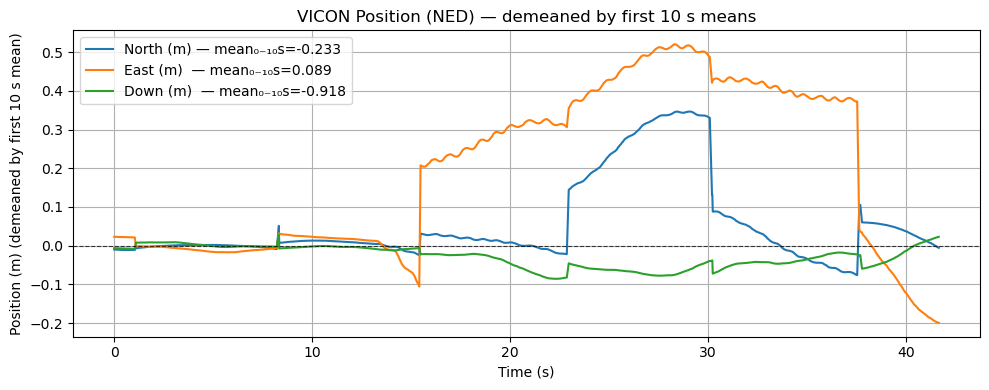

In [10]:
import numpy as np
import matplotlib.pyplot as plt

time_s = df["t_rel"].to_numpy()
north  = df["pos_north"].to_numpy()
east   = df["pos_east"].to_numpy()
down   = df["pos_down"].to_numpy()

# First 10 s window (works even if t_rel doesn't start at 0)
t0 = float(time_s[0])
mask10 = (time_s - t0) <= 10.0
if not np.any(mask10):     # fallback if trace is shorter than 10 s
    mask10 = np.ones_like(time_s, dtype=bool)

# Per-axis means over the first 10 s
mN = float(np.nanmean(north[mask10]))
mE = float(np.nanmean(east[mask10]))
mD = float(np.nanmean(down[mask10]))

# Demean each axis
north_dm = north - mN
east_dm  = east  - mE
down_dm  = down  - mD

# Optional: print them too
print(f"First 10s means — North: {mN:.3f} m, East: {mE:.3f} m, Down: {mD:.3f} m")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time_s, north_dm, label=f"North (m) — mean₀₋₁₀s={mN:.3f}")
plt.plot(time_s, east_dm,  label=f"East (m)  — mean₀₋₁₀s={mE:.3f}")
plt.plot(time_s, down_dm,  label=f"Down (m)  — mean₀₋₁₀s={mD:.3f}")

plt.axhline(0.0, ls='--', lw=0.8, c='k', alpha=0.7)  # zero baseline after demeaning
plt.xlabel("Time (s)")
plt.ylabel("Position (m) (demeaned by first 10 s mean)")
plt.title("VICON Position (NED) — demeaned by first 10 s means")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


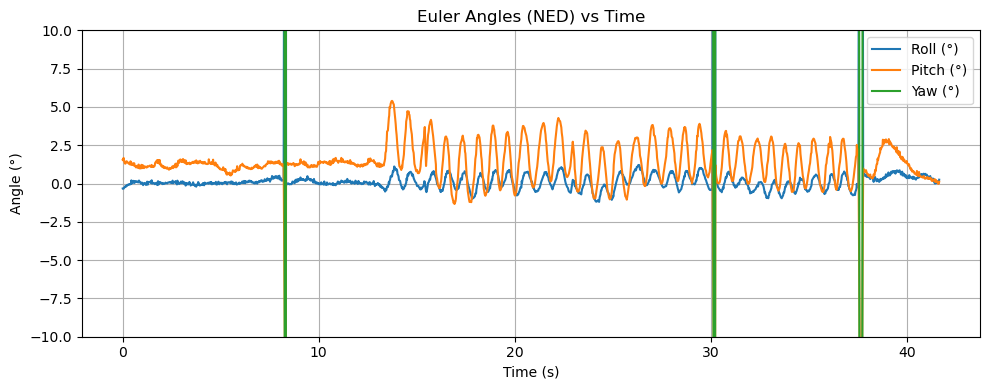

In [16]:
plt.figure(figsize=(10,4))
plt.plot(time_s, roll_deg,  label="Roll (°)")
plt.plot(time_s, pitch_deg, label="Pitch (°)")
plt.plot(time_s, yaw_deg,   label="Yaw (°)")
plt.ylim([-10,10])
plt.xlabel("Time (s)"); plt.ylabel("Angle (°)")
plt.title("Euler Angles (NED) vs Time")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [17]:
import numpy as np

# --- Build delta (demeaned) Euler angles using the first 10 s ---
time_s    = np.asarray(time_s).ravel()
roll_deg  = np.asarray(roll_deg).ravel()
pitch_deg = np.asarray(pitch_deg).ravel()
yaw_deg   = np.asarray(yaw_deg).ravel()

# Align lengths (safety)
N = min(len(time_s), len(roll_deg), len(pitch_deg), len(yaw_deg))
time_s, roll_deg, pitch_deg, yaw_deg = time_s[:N], roll_deg[:N], pitch_deg[:N], yaw_deg[:N]

# First-10s window (robust if time doesn't start at 0)
t0 = float(time_s[0])
mask10 = (time_s - t0) <= 10.0
if not np.any(mask10):  # fallback if trace shorter than 10 s
    mask10 = np.ones_like(time_s, dtype=bool)

# Means over first 10 s
m_roll  = float(np.nanmean(roll_deg[mask10]))
m_pitch = float(np.nanmean(pitch_deg[mask10]))
m_yaw   = float(np.nanmean(yaw_deg[mask10]))

# Delta (demeaned) Euler angles
droll  = roll_deg  - m_roll
dpitch = pitch_deg - m_pitch
dyaw   = yaw_deg   - m_yaw

print(f"First 10 s means — roll: {m_roll:.2f}°, pitch: {m_pitch:.2f}°, yaw: {m_yaw:.2f}°")


First 10 s means — roll: 0.28°, pitch: 1.13°, yaw: 87.14°


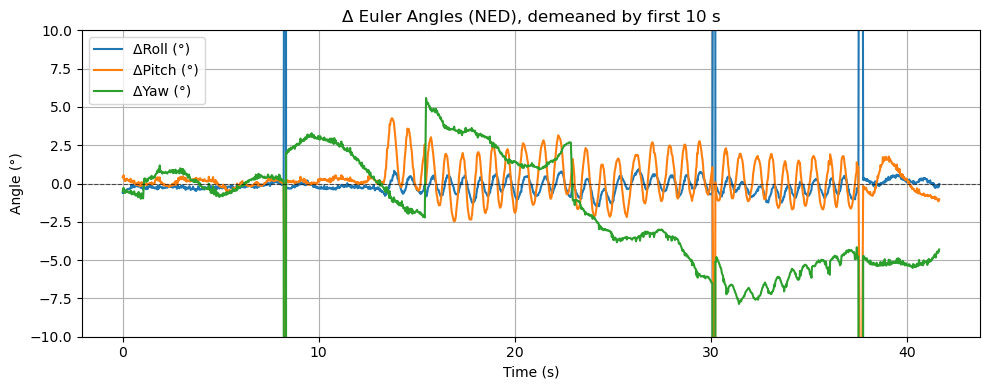

In [18]:
plt.figure(figsize=(10,4)) 
plt.plot(time_s, droll,  label="ΔRoll (°)")
plt.plot(time_s, dpitch, label="ΔPitch (°)")
plt.plot(time_s, dyaw,   label="ΔYaw (°)")
plt.axhline(0.0, ls='--', c='k', lw=0.8, alpha=0.6)
plt.ylim(-10, 10)
plt.xlabel("Time (s)"); plt.ylabel("Angle (°)")
plt.title("Δ Euler Angles (NED), demeaned by first 10 s")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


VECHILE ODOMETRY

In [21]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

# --- Load the CSV file ---
df = pd.read_csv("/home/cpsl/px4_ws/attack3_log36/csv_out/cpsl_uav_7__fmu__out__vehicle_odometry.csv")

# Show basic info
print("Data summary:")
df.info()

# Display first few rows
df.head()




Data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147 entries, 0 to 4146
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   t                     4147 non-null   float64
 1   t_rel                 4147 non-null   float64
 2   timestamp             4147 non-null   int64  
 3   timestamp_sample      4147 non-null   int64  
 4   pose_frame            4147 non-null   int64  
 5   position              4147 non-null   object 
 6   q                     4147 non-null   object 
 7   velocity_frame        4147 non-null   int64  
 8   velocity              4147 non-null   object 
 9   angular_velocity      4147 non-null   object 
 10  position_variance     4147 non-null   object 
 11  orientation_variance  4147 non-null   object 
 12  velocity_variance     4147 non-null   object 
 13  reset_counter         4147 non-null   int64  
 14  quality               4147 non-null   int64  
dtypes: floa

,t,t_rel,timestamp,timestamp_sample,pose_frame,position,q,velocity_frame,velocity,angular_velocity,position_variance,orientation_variance,velocity_variance,reset_counter,quality
0,1.760387e+09,0.105878,1760387117455935,1760387117455116,1,[-0.2032192 0.0835785 -0.91051304],[ 0.1145537 0.01306202 -0.00475619 0.99331987],1,[-0.01618541 0.01337635 0.01543608],[-0.0364178 -0.0088465 0.00727055],[0.0038464 0.00384899 0.00054672],[2.3303573e-05 1.2572386e-05 1.6856877e-02],[0.00108137 0.0010813 0.0011956 ],30,0
1,1.760387e+09,0.116139,1760387117465868,1760387117465132,1,[-0.2032624 0.08366017 -0.9103689 ],[ 0.11451469 0.01309522 -0.00498753 0.99332273],1,[-0.01220956 0.00787593 0.02600382],[-0.05530974 0.00489216 0.01643554],[0.00385837 0.00386092 0.00053532],[2.3165516e-05 1.2509094e-05 1.6858302e-02],[0.00110225 0.00110181 0.00118307],30,0
2,1.760387e+09,0.125938,1760387117476009,1760387117475148,1,[-0.20334327 0.08367307 -0.9102455 ],[ 0.11453203 0.01305195 -0.00523756 0.9933201 ],1,[0.00088924 0.00656076 0.02041551],[-0.03576185 0.01032145 -0.00944343],[0.00385792 0.00386044 0.00054663],[2.2948940e-05 1.2353216e-05 1.6859770e-02],[0.00108107 0.00108214 0.00119556],30,0
3,1.760387e+09,0.136253,1760387117485864,1760387117485166,1,[-0.20340939 0.08367411 -0.9100642 ],[ 0.1145269 0.01308478 -0.00546472 0.993319 ],1,[-0.01369402 0.00723056 0.01934455],[-0.07528848 -0.00321903 0.00441089],[0.00386987 0.00387234 0.00055819],[2.2836623e-05 1.2261563e-05 1.6861208e-02],[0.00110124 0.00110281 0.00120805],30,0
4,1.760387e+09,0.145923,1760387117496069,1760387117495226,1,[-0.2034399 0.08372276 -0.909908 ],[ 0.1145388 0.01312109 -0.00552471 0.9933168 ],1,[-0.01221663 0.00818494 0.0284914 ],[ 0.01512657 -0.05077157 0.00186014],[0.00387279 0.0038752 0.00054607],[2.2504222e-05 1.2177720e-05 1.6862744e-02],[0.00109154 0.00109116 0.0011945 ],30,0


In [22]:

# --- Robust array parser for PX4-style fields ---
def parse_array_column(series):
    arr_list = []
    for s in series:
        if not isinstance(s, str):
            arr_list.append([np.nan, np.nan, np.nan])
            continue
        # Clean up brackets and spacing
        s_clean = s.strip()
        s_clean = s_clean.strip('[]')              # remove brackets
        s_clean = re.sub(r'\s+', ',', s_clean)     # replace spaces with commas
        s_clean = re.sub(r',+', ',', s_clean)      # remove duplicate commas
        s_clean = s_clean.strip(',')               # trim leading/trailing commas
        try:
            arr = np.array([float(x) for x in s_clean.split(',')])
        except ValueError:
            arr = np.array([np.nan, np.nan, np.nan])
        arr_list.append(arr)
    return np.vstack(arr_list)

# --- Parse array fields ---
pos = parse_array_column(df["position"])
quat = parse_array_column(df["q"])
vel = parse_array_column(df["velocity"])
angvel = parse_array_column(df["angular_velocity"])

# --- Quaternion → Euler (NED frame, PX4 convention) ---
qx, qy, qz, qw = quat[:,0], quat[:,1], quat[:,2], quat[:,3]

roll  = np.arctan2(2*(qw*qx + qy*qz), 1 - 2*(qx**2 + qy**2))
pitch = np.arcsin(2*(qw*qy - qz*qx))
yaw   = np.arctan2(2*(qw*qz + qx*qy), 1 - 2*(qy**2 + qz**2))

roll_deg, pitch_deg, yaw_deg = np.degrees(roll), np.degrees(pitch), np.degrees(yaw)

# --- Add parsed columns ---
df["x"], df["y"], df["z"] = pos[:,0], pos[:,1], pos[:,2]
df["roll_deg"], df["pitch_deg"], df["yaw_deg"] = roll_deg, pitch_deg, yaw_deg
df["wx"], df["wy"], df["wz"] = angvel[:,0], angvel[:,1], angvel[:,2]

# --- Time base ---
t = df["t_rel"]


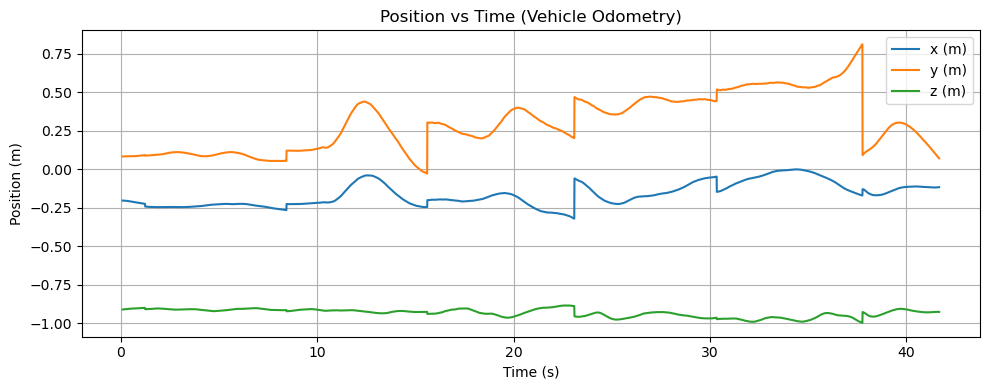

In [23]:

# --- Plot 1: Position ---
plt.figure(figsize=(10,4))
plt.plot(t, df["x"], label="x (m)")
plt.plot(t, df["y"], label="y (m)")
plt.plot(t, df["z"], label="z (m)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time (Vehicle Odometry)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


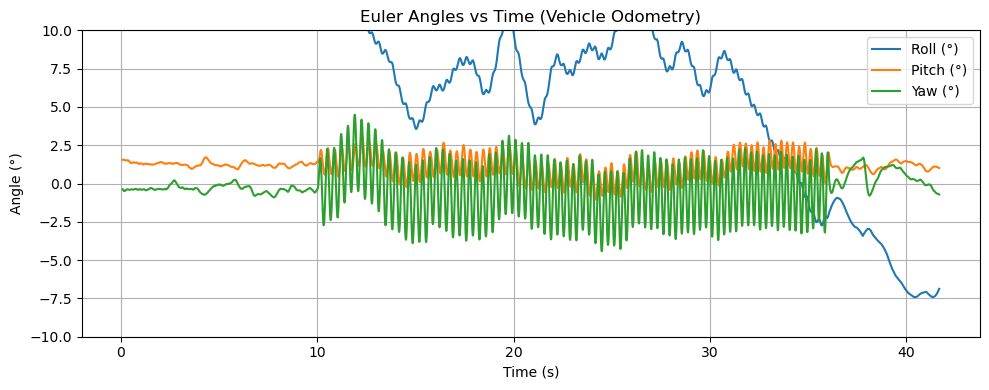

In [24]:

# --- Plot 2: Euler angles ---
plt.figure(figsize=(10,4))
plt.plot(t, df["roll_deg"], label="Roll (°)")
plt.plot(t, df["pitch_deg"], label="Pitch (°)")
plt.plot(t, df["yaw_deg"], label="Yaw (°)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (°)")
plt.title("Euler Angles vs Time (Vehicle Odometry)")
plt.ylim(-10, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


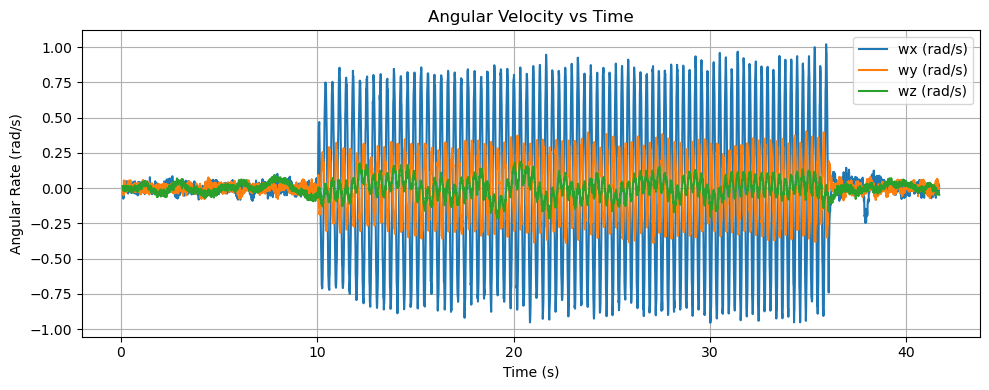

In [25]:

# --- Plot 3: Angular rates ---
plt.figure(figsize=(10,4))
plt.plot(t, df["wx"], label="wx (rad/s)")
plt.plot(t, df["wy"], label="wy (rad/s)")
plt.plot(t, df["wz"], label="wz (rad/s)")
plt.xlabel("Time (s)")
plt.ylabel("Angular Rate (rad/s)")
plt.title("Angular Velocity vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SENSOR_COMBINED

In [26]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

# --- Load the CSV file ---
df = pd.read_csv("/home/cpsl/px4_ws/attack3_log36/csv_out/cpsl_uav_7__fmu__out__sensor_combined.csv")

# Show basic info
print("Data summary:")
df.info()

# Display first few rows
df.head()




Data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   t                                 4157 non-null   float64
 1   t_rel                             4157 non-null   float64
 2   timestamp                         4157 non-null   int64  
 3   gyro_rad                          4157 non-null   object 
 4   gyro_integral_dt                  4157 non-null   int64  
 5   accelerometer_timestamp_relative  4157 non-null   int64  
 6   accelerometer_m_s2                4157 non-null   object 
 7   accelerometer_integral_dt         4157 non-null   int64  
 8   accelerometer_clipping            4157 non-null   int64  
 9   gyro_clipping                     4157 non-null   int64  
 10  accel_calibration_count           4157 non-null   int64  
 11  gyro_calibration_count            4157 non-null   int64

,t,t_rel,timestamp,gyro_rad,gyro_integral_dt,accelerometer_timestamp_relative,accelerometer_m_s2,accelerometer_integral_dt,accelerometer_clipping,gyro_clipping,accel_calibration_count,gyro_calibration_count
0,1.760387e+09,0.106176,1760387117455116,[-0.0372806 -0.00888146 0.00751898],2504,0,[ 1.9091864 -1.802848 -11.137877 ],2504,0,0,1,1
1,1.760387e+09,0.116261,1760387117465132,[-0.05617254 0.00485721 0.01668397],2504,0,[ 1.6392473 3.2154138 -10.890167 ],2504,0,0,1,1
2,1.760387e+09,0.126006,1760387117475148,[-0.03662844 0.01028457 -0.00919496],2504,0,[-3.3729131 -0.1561035 -7.650547 ],2504,0,0,1,1
3,1.760387e+09,0.136354,1760387117485166,[-0.07615508 -0.00325591 0.00465936],2503,0,[ -1.1294727 -2.666051 -10.665044 ],2503,0,0,1,1
4,1.760387e+09,0.145864,1760387117495226,[ 0.01426346 -0.0508089 0.00210856],2547,0,[ 1.6701828 2.3873446 -8.636495 ],2547,0,0,1,1
